In [1]:
#!pip install torch==1.5.1+cu101 torchvision==0.6.1+cu101 -f https://download.pytorch.org/whl/torch_stable.html

In [2]:
"""
!pip install torch-scatter==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.5.0.html
!pip install torch-sparse==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.5.0.html
!pip install torch-cluster==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.5.0.html
!pip install torch-spline-conv==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.5.0.html
!pip install torch-geometric
"""

'\n!pip install torch-scatter==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.5.0.html\n!pip install torch-sparse==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.5.0.html\n!pip install torch-cluster==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.5.0.html\n!pip install torch-spline-conv==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.5.0.html\n!pip install torch-geometric\n'

In [1]:
from torch.autograd import Variable
import torch_geometric.transforms
from torch_geometric.transforms import knn_graph
import torch_geometric.data
import torch 
from torch_geometric.data import Data
import numpy as np
import pandas as pd
from scipy.spatial import distance_matrix
import torch
import pyarrow as pa
import pyarrow.parquet as pq
import h5py
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from torch_geometric.nn import knn_graph
import os 
from itertools import cycle,islice
from torch.utils.data import *
from functools import partial
import timeit

In [2]:

import argparse
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
parser = argparse.ArgumentParser()
#parser.add_argument('--seed', type=int, default=42, help='Random seed.')
parser.add_argument('--epochs', type=int, default=50, help='Number of epochs to train.')
parser.add_argument('--batch_size', type=int, default=64, help='Initial learning rate.') #100
parser.add_argument('--maxnodes', type=int, default=1000, help='max nodes.') #100
parser.add_argument('--lr', type=float, default=0.001, help='Initial learning rate.') #0.001
parser.add_argument('--dropout', type=float, default=0.3, help='Dropout rate (1 - keep probability).')
args = parser.parse_args([])
torch.backends.cudnn.benchmark = True

In [3]:
class ParquetDataset(Dataset):
    def __init__(self, filename):
        self.parquet = pq.ParquetFile(filename)
        self.cols = None 
    def __getitem__(self, index):
        data = self.parquet.read_row_group(index, columns=self.cols).to_pydict()
        data['X_jets'] = np.float32(data['X_jets'][0]) 
        # Preprocessing
        data['X_jets'] = data['X_jets'][1]
        data['X_jets'][data['X_jets'] < 1.e-3] = 0. # Zero-Suppression
        return dict(data)
    def __len__(self):
        return self.parquet.num_row_groups

In [4]:
def get_data_loader(datasets, batch_size, cut, random_sampler=True):
    dset = ConcatDataset([ParquetDataset(dataset) for dataset in datasets])
    idxs = np.random.permutation(len(dset))
    if random_sampler: 
        random_sampler = sampler.SubsetRandomSampler(idxs[:cut])
    else: 
        random_sampler = None
    data_loader = DataLoader(dataset=dset, batch_size=batch_size, shuffle=False, num_workers=10, sampler=random_sampler, pin_memory=True)
    return data_loader

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
cd drive/My\ Drive/parquets

/content/drive/My Drive/parquets


In [7]:
datasets = ['Boosted_Jets_Sample-%i.snappy.parquet'%i for i in range(1)]
data_loader = get_data_loader(datasets, args.batch_size, cut = None, random_sampler = True)

In [8]:
valsets = ['Boosted_Jets_Sample-%i.snappy.parquet'%i for i in range(2,3)]
VaLoader = get_data_loader(valsets, args.batch_size, cut = None, random_sampler = True)

In [9]:
import torch_geometric.transforms
from torch_geometric.nn import knn_graph
import torch_geometric.data
import torch 
from torch_geometric.data import Data
import numpy as np
def torchjets(datei,number1,number2):

    cols = None

    graphs=[]

    for i in range(number1,number2):

      ecal=datei[i]

      xhit2,yhit2=torch.nonzero(ecal,as_tuple=True)  ## Select hits in detector

      eneEcal=-torch.log(ecal[xhit2,yhit2])/15 ## Select energies of hits

      feats=torch.stack((xhit2.float(),yhit2.float(),eneEcal),dim=1) ## concatenate x,y locations and energies (3 features in total)
      cords=feats[:,[0,1]].cuda() ## cords = x,y coordinates 
      feats[:,0]-=60
      feats[:,0]/=125
      feats[:,1]-=60
      feats[:,1]/=125
      edge_index = knn_graph(cords[:args.maxnodes], k=6, batch=None, loop=True)  ## Create knn graph adjacency matrix 

      donnees=Data(x=feats[:args.maxnodes],edge_index=edge_index) ## Create graph data with feature matrix x and adjacency matrix edge_index
      
      graphs.append(donnees)

    return graphs

In [10]:
cd ../v22/version3

/content/drive/My Drive/v22/version3


In [11]:
import VAE_version2#DiffAE

In [12]:
model3=VAE_version2.GraphAE(3,64,128,256,64,128,256, args.maxnodes)#DiffAE.GraphAE()
model3.train()
model3.to(device)

GraphAE(
  (sage1): DenseSAGEConv(3, 64)
  (sage2): DenseSAGEConv(64, 128)
  (sage3): DenseSAGEConv(128, 256)
  (sage5): DenseSAGEConv(256, 128)
  (poolit1): Linear(in_features=128, out_features=400, bias=True)
  (poolit2): Linear(in_features=256, out_features=16, bias=True)
  (tr2): Linear(in_features=128, out_features=64, bias=True)
  (rev2): Linear(in_features=64, out_features=128, bias=True)
  (revsage1): DenseSAGEConv(64, 3)
  (revsage2): DenseSAGEConv(128, 64)
  (revsage3): DenseSAGEConv(256, 128)
  (revsage5): DenseSAGEConv(128, 256)
  (drop5): Dropout(p=0.5, inplace=False)
  (drop4): Dropout(p=0.4, inplace=False)
  (drop3): Dropout(p=0.3, inplace=False)
  (bano1): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bano2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bano3): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bano4): BatchNorm1d(400, eps=1e-05, momentum=0.1,

In [13]:
optimizer = torch.optim.Adam(model3.parameters(), lr=args.lr)
#optimizer = torch.optim.SGD(model3.parameters(), lr=args.lr, momentum=0.9)

In [14]:
"""
checkpoint = torch.load('loadBatches_b16_pool3.pth')
model3.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
for state in optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.cuda()
model3.eval()
model3.to(device)
"""

"\ncheckpoint = torch.load('loadBatches_b16_pool3.pth')\nmodel3.load_state_dict(checkpoint['model_state_dict'])\noptimizer.load_state_dict(checkpoint['optimizer_state_dict'])\nfor state in optimizer.state.values():\n    for k, v in state.items():\n        if isinstance(v, torch.Tensor):\n            state[k] = v.cuda()\nmodel3.eval()\nmodel3.to(device)\n"

In [15]:
scaler = torch.cuda.amp.GradScaler() 

In [16]:
## generate list to count nodes for each graph
def nodeCounter(samples):
    inds=[]
    for k in samples:
        inds.append(k['x'].shape[0])
    return inds

In [17]:
def ref(bsize,nodeC,i1,i2):
  maxC=np.max(np.array(nodeC))
  maxC=args.maxnodes#maxC + (4 - maxC % 4) ##max num of nodes 1161%4
  refMat=np.zeros((bsize,maxC)) ## matrix of zeros
  for pi in range(i1,i2):##10
    refMat[pi,:nodeC[pi]]=1 ## fill ones 
  return refMat,maxC

In [18]:
def assigner(nodelist):
  fin=[]
  countit=0
  for m in nodelist:
      fin.append(np.repeat(countit,m))
      countit+=1
  return np.array(fin)

In [19]:
from optimizer import loss_function

In [20]:
#from torch.cuda.amp import GradScaler, autocast

In [21]:
import time
from torch_geometric.utils import to_dense_batch, to_dense_adj
for epoch in range(10):
      #model.train()
  count=0
  c1,c2=0,args.batch_size
  epLoss=0
  t = time.time()
  for i, data in enumerate(data_loader):
        ecal2 = data['X_jets'].cuda()
        rawGraph=torchjets(ecal2,0,args.batch_size) ##Generating graphs from raw data 
        nodeCount=nodeCounter(rawGraph)
        lengs=torch.LongTensor(np.hstack(assigner(np.array(nodeCount[c1:c2])))).cuda()
        
        compress=torch_geometric.data.Batch.from_data_list(rawGraph)

        gra=compress.x.clone()
        adj=compress.edge_index.clone()

        count+=1
        refMat,maxCount=ref(args.batch_size,nodeCount,c1,c2)
        
        
        mask=torch.from_numpy(refMat).to(device) 
        #maxi=torch.from_numpy(np.array(maxCount)).to(device)
        whole,mask=to_dense_batch(gra, lengs, fill_value=0, max_num_nodes=args.maxnodes)#refMat.shape[1])
        wholeAdj=to_dense_adj(adj, lengs, edge_attr=None, max_num_nodes=args.maxnodes).cuda()#refMat.shape[1]).cuda()

        whole=whole.cuda()
        mask=mask.cuda()
        lengs=lengs.cuda()
        
        optimizer.zero_grad()

        r1 ,adj1,mu,sig,m_loss,o_loss= model3(whole,wholeAdj,lengs,mask,args.maxnodes)

        #sparse=to_sparse_batch(r1, adj1, mask=torch.LongTensor(mask).cuda())

        loss = loss_function(r1,whole,nodeCount,lengs,args.maxnodes,mu,sig)/args.batch_size+m_loss+o_loss

        loss.backward()

        optimizer.step()

        #model3.zero_grad()

        cur_loss = loss.item()
        
        epLoss+=float(cur_loss)

        if count%230==0:
            print("Epoch:", '%04d' % (epoch + 1), "train_loss=", "{:.5f}".format(epLoss/count),"time=", "{:.5f}".format(time.time() - t))
            t = time.time()

            with torch.no_grad():
              model3.eval()
              VaLoss=0
              c3,c4=0,args.batch_size
              for data2 in islice(VaLoader,0,1):
                ecal3 = data2['X_jets'].cuda()
                rawGraph3=torchjets(ecal3,0,args.batch_size) ##Generating graphs from raw data 
                nodeCount3=nodeCounter(rawGraph3)
                lengs3=torch.LongTensor(np.hstack(assigner(np.array(nodeCount3[c3:c4])))).cuda()
                
                compress3=torch_geometric.data.Batch.from_data_list(rawGraph3)

                gra3=compress3.x
                adj3=compress3.edge_index
                #refMat3,maxCount3=ref(args.batch_size,nodeCount,c3,c4)
                #mask3=torch.from_numpy(refMat3).to(device) 
                #maxi=torch.from_numpy(np.array(maxCount)).to(device)
                whole3,mask3=to_dense_batch(gra3, lengs3, fill_value=0, max_num_nodes=args.maxnodes)#refMat.shape[1])
                wholeAdj3=to_dense_adj(adj3, lengs3, edge_attr=None, max_num_nodes=args.maxnodes).cuda()#refMat.shape[1]).cuda()

                whole3=whole3.cuda()
                mask3=mask3.cuda()
                lengs3=lengs3.cuda()

                r13 ,adj13,mu3,sig3,m_loss3,o_loss3= model3(whole3,wholeAdj3,lengs3,mask3,args.maxnodes)
                loss3 = loss_function(r13,whole3,nodeCount,lengs3,args.maxnodes,mu3,sig3)/args.batch_size+m_loss3+o_loss3
                cur_loss3 = loss3.item()

              print("Val Loss:", '%04d' % (cur_loss3))

  torch.save({
        'epoch': epoch,
        'model_state_dict': model3.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch':epoch,
        'loss': loss,
        'epLoss':epLoss
        }, './loadBatches_b16_pool3.pth')


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 0001 train_loss= 0.67714 time= 215.22499
Val Loss: 0000
Epoch: 0001 train_loss= 0.63618 time= 215.56477
Val Loss: 0000
Epoch: 0002 train_loss= 0.55433 time= 215.10687
Val Loss: 0000
Epoch: 0002 train_loss= 0.55108 time= 217.00280
Val Loss: 0000
Epoch: 0003 train_loss= 0.54354 time= 215.13080
Val Loss: 0000
Epoch: 0003 train_loss= 0.54218 time= 217.42708
Val Loss: 0000
Epoch: 0004 train_loss= 0.53772 time= 214.41895
Val Loss: 0000
Epoch: 0004 train_loss= 0.53709 time= 218.07176
Val Loss: 0000
Epoch: 0005 train_loss= 0.53388 time= 215.80485
Val Loss: 0000
Epoch: 0005 train_loss= 0.53399 time= 217.92570
Val Loss: 0000


KeyboardInterrupt: ignored

In [ ]:
o_loss


In [22]:
testsets = ['../../parquets/Boosted_Jets_Sample-%i.snappy.parquet'%i for i in range(3,4)]
testloader = get_data_loader(testsets, args.batch_size, cut = None, random_sampler = True)

In [23]:
import time
import time
from torch_geometric.utils import to_dense_batch, to_dense_adj
for epoch in range(1):
      #model.train()
  count=0
  c5,c6=0,args.batch_size
  epLoss=0
  t = time.time()
  model3.eval()
  with torch.no_grad():
    for k, data4 in enumerate(testloader):
          ecal4 = data4['X_jets'].cuda()
          rawGraph4=torchjets(ecal4,0,args.batch_size) ##Generating graphs from raw data 
          nodeCount4=nodeCounter(rawGraph4)
          lengs4=torch.LongTensor(np.hstack(assigner(np.array(nodeCount4[c5:c6])))).cuda()
          
          compress4=torch_geometric.data.Batch.from_data_list(rawGraph4)

          gra4=compress4.x
          adj4=compress4.edge_index

          whole4,mask4=to_dense_batch(gra4, lengs4, fill_value=0, max_num_nodes=1000)#refMat.shape[1])
          wholeAdj4=to_dense_adj(adj4, lengs4, edge_attr=None, max_num_nodes=1000).cuda()#refMat.shape[1]).cuda()

          count+=1
          refMat4,maxCount4=ref(args.batch_size,nodeCount4,c5,c6)
          
          #mask4=torch.from_numpy(refMat4).to(device)
          #maxi=torch.from_numpy(np.array(maxCount)).to(device)

          rand1=torch.rand(args.batch_size,args.maxnodes,3)
          rand2=torch.rand(args.batch_size,args.maxnodes,args.maxnodes)

          r14 ,adj4,mu4,sig4,mc_loss4,o_loss4= model3(whole4,wholeAdj4,lengs4.to(device),mask4.cuda(),args.maxnodes)

          loss4 = loss_function(r14,wholeAdj4,nodeCount4,lengs4,args.maxnodes,mu4,sig4)/args.batch_size+mc_loss4+o_loss4

          cur_loss4 = loss4.item()
      


          #c1+=args.batch_size
          #c2+=args.batch_size
          if count%1==0:
              print("Epoch:", '%04d' % (epoch + 1), "train_loss=", "{:.5f}".format(epLoss4/count),"time=", "{:.5f}".format(time.time() - t))
              t = time.time()
              break;

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


NameError: ignored

In [ ]:
mu[0]


In [25]:

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.colors import LogNorm

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


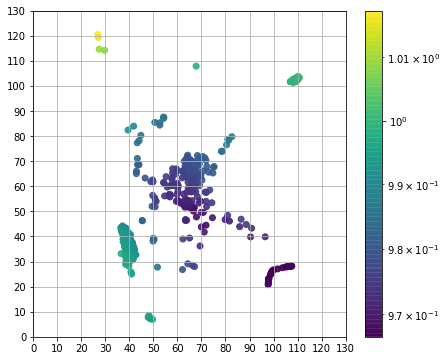

In [35]:
%matplotlib inline
#xmin, xmax = min(lis4[:,0]), max(lis4[:,0])
#ymin, ymax = min(lis4[:,1]), max(lis4[:,1])
r12=r13[2].cpu().clone()
xmin,xmax=0,125
ymin,ymax=0,125
binsxy = [int((xmax - xmin) / 50), int((ymax - ymin) / 50)]
weights=np.exp(-r12[:1000,2]/15)
plt.figure(figsize=(7,6))
sc = plt.scatter(r12[:1000,0]*125+60,r12[:1000,1]*125+60,c=weights,cmap='viridis', norm=LogNorm(),alpha=0.9)
plt.colorbar(sc)
check=np.arange(0,140,10)
plt.xticks(check)
plt.yticks(check)
plt.grid()


In [27]:
r12

tensor([[ 0.0154,  0.0137, -0.0156],
        [ 0.0154,  0.0137, -0.0156],
        [ 0.0154,  0.0137, -0.0156],
        ...,
        [ 0.0154,  0.0137, -0.0156],
        [ 0.0154,  0.0137, -0.0156],
        [ 0.0154,  0.0137, -0.0156]])

In [ ]:
for param in model3.parameters():
  print(param.data.shape)

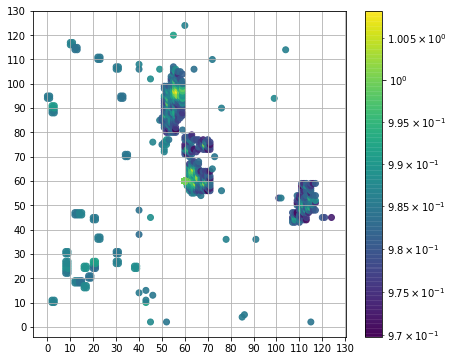

In [34]:
%matplotlib inline
r12=whole4[2].cpu().numpy().copy()
xmin,xmax=0,125
ymin,ymax=0,125
binsxy = [int((xmax - xmin) / 50), int((ymax - ymin) / 50)]
weights=np.exp(-r12[:1000,2]/15)
plt.figure(figsize=(7,6))
sc = plt.scatter(r12[:1000,0]*125+60,r12[:1000,1]*125+60,c=weights,cmap='viridis', norm=LogNorm(),alpha=0.9)
plt.colorbar(sc)
check=np.arange(0,140,10)
plt.xticks(check)
plt.yticks(check)
plt.grid()


In [ ]:
gra